In [1]:
# importing packages and modules
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.optimize import minimize
from utils import *
from plotting_utils import *
from analysis_utils import *
import dglm_hmm1
from scipy.stats import multivariate_normal, norm
# import jax

# code from summer project working with PWM data
import sys, os
sys.path.append(os.path.abspath(os.path.join('..', '..', 'LC_PWM_GLM-HMM/code')))
import io_utils, analysis_utils, plotting_utils

sns.set_context("talk")

In [2]:
# rat ids to look at first
animal_ids = ['W073']

In [5]:
pni_path = '/Users/lencacuturela/Desktop/github/LC_PWM_GLM-HMM/data'
laptop_path = '/Users/lencacuturela/Desktop/Research/github/LC_PWM_GLM-HMM/data'

### Doing psychometric function

(100835, 2, 6, 2)
[[-0.84104143 -1.16538089  2.05959304]
 [ 3.31225323 -5.2510334   3.42949782]]


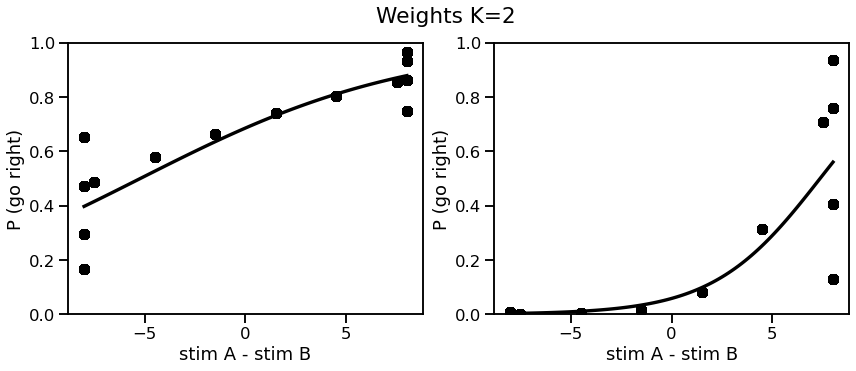

In [50]:
def psychometric(Wt, xt):
    ''' 

    calculating psychometric function based on bias, stimulus 1, and stimulus 2 

    Parameters
    ----------
    Wt: D x C numpy array
        matrix of weights at a certain time
    xt: D x 1 numpy vector
        features at a certain time
    Returns
    -------
    beta: T x k numpy array 
    matrix of backward conditional probabilities p(y_t+1:T | z_t) / p(y_t+1:T | y_1:t)
        

    '''
    K = Wt.shape[0]
    D = Wt.shape[1]
    C = Wt.shape[2]

    return softplus_deriv(-Wt[:,:,1].T@xt)

rat_id = 'W075'
stage_filter = 3
K = 2
fold = 0
penaltyW = True
path = laptop_path
x, y = io_utils.prepare_design_matrices(rat_id=rat_id, path=path, psychometric=True, cutoff=10, stage_filter=stage_filter, overwrite=False)
df = io_utils.load_and_wrangle(rat_id = rat_id, path=path, psychometric=True, cutoff=10, stage_filter=stage_filter, overwrite=False)
sessInd = list(io_utils.session_start(rat_id=rat_id, path=path, psychometric=True, cutoff=10, stage_filter=stage_filter)) 
deltaStim = np.array(df["s_a"] - df["s_b"])

def plot_psychometric_per_state(Wt, x, deltaStim, axes):
    ''' 
    calculating psychometric function based on bias, stimulus 1, and stimulus 2 

    Parameters
    ----------
    Wt: K x C numpy array
        matrix of weights at a certain time
    xt: N x 3 numpy vector
        features across time for bias, stim A, stim B in this order
    Returns
    -------
    beta: T x k numpy array 
    matrix of backward conditional probabilities p(y_t+1:T | z_t) / p(y_t+1:T | y_1:t)
        

    '''
    K = Wt.shape[0]
    D = Wt.shape[1]
    # deltaStim = x[:,1]-x[:,2]
    
    for k in range(0,K):
        psych = np.array([softplus_deriv(-Wt[k,:]@x[t]) for t in range(0,x.shape[0])])
        if (K==1):
            axes.scatter(deltaStim, psych, color='black')
            sns.regplot(x=deltaStim, y=psych, logistic=True, ci=None, color="black", ax=axes)
            # axes[k].set_xlim(-1,1)
            axes.set_ylim(0,1)
            axes.set_ylabel("P (go right)")
            axes.set_xlabel('stim A - stim B')
        else:
            axes[k].scatter(deltaStim, psych, color='black')
            sns.regplot(x=deltaStim, y=psych, logistic=True, ci=None, color="black", ax=axes[k])
            # axes[k].set_xlim(-1,1)
            axes[k].set_ylim(0,1)
            axes[k].set_ylabel("P (go right)")
            axes[k].set_xlabel('stim A - stim B')
fig, axes = plt.subplots(1, K, figsize=(K*6+2,5))
allW = np.load(f'../data_PWM/W_PWM_{rat_id}_sf={stage_filter}_{K}_state_fold-{fold}_multiple_sigmas_penaltyW={penaltyW}.npy')
print(allW[5].shape)
bias = 3
weightA = -5
weightB = 3
idealW = np.array([bias,weightA,weightB]).reshape((1,3))
# fig.suptitle(f'Hypothetical Weights: bias={bias}, stimA={weightA}, stimB={weightB}')
# plot_psychometric_per_state(idealW, x[:,0:3], deltaStim, axes)
print(allW[5,60000,:,0:3,1])
fig.suptitle(f'Weights K={K}')
plot_psychometric_per_state(allW[5,60000,:,0:3,1], x[:,0:3], deltaStim, axes)

In [ ]:
glmhmmW = np.load(f'../data_PWM/W-global_PWM_all-animals_sf=4_{K}_state_multiple_inits_L2penaltyW=1.npy')[bestInd]

### Data Prep and CV

In [4]:
df = io_utils.load_and_wrangle(rat_id='W073', path=None, psychometric=True, cutoff=10, overwrite=False, stage_filter=3)
print(len(df.index.tolist()))
print(df.iloc[20000,:])
x, y = io_utils.prepare_design_matrices(rat_id='W073', path=None, psychometric=True, cutoff=10, stage_filter=3, overwrite=False)
sessInd = list(io_utils.session_start(rat_id='W073', path=None, psychometric=True, cutoff=10, stage_filter=3))



146675
subject_id        W073
session            179
trial                9
s_a               84.0
s_b               76.0
choice             1.0
correct_side         1
hit                1.0
delay              3.1
training_stage       4
Name: 20000, dtype: object


In [5]:
folds = 3
trainX, trainY, trainSessInd, testX, testY, testSessInd = split_data_per_session(x, y, sessInd, folds=3, random_state=1)

### Fitting single sigma

In [27]:
N = x.shape[0]
C = 2 # classes
K = 2 # states
D = x.shape[1]
dGLM_HMM = dglm_hmm1.dGLM_HMM1(N,K,D,C)
initP, initW = dGLM_HMM.generate_param(sessInd=sessInd, transitionDistribution=['dirichlet', (5, 1)], weightDistribution=['uniform', (-2,2)]) # initialize the model parameters
checkP, checkW, checkLl = dGLM_HMM.fit(x, y,  initP, initW, sigma= reshapeSigma(0.1, K, D), sessInd=sessInd, pi0=None, maxIter=2, tol=1e-4) # fit the model
print(np.argmax(checkLl))

KeyboardInterrupt: 

In [5]:
for k in [1,2]:
    N = x.shape[0]
    C = 2 # classes
    K = k # states
    D = x.shape[1]
    dGLM_HMM = dglm_hmm1.dGLM_HMM1(N,K,D,C)
    initP, initW = dGLM_HMM.generate_param(sessInd=sessInd, transitionDistribution=['dirichlet', (5, 1)], weightDistribution=['uniform', (-2,2)]) # initialize the model parameters
    checkP, checkW, checkLl = dGLM_HMM.fit(x, y,  initP, initW, sigma= reshapeSigma(0.1, K, D), sessInd=sessInd, pi0=None, maxIter=250, tol=1e-3) # fit the model
    np.save(f'../data/P_{k}_state_PWM', checkP)
    np.save(f'../data/Ll_{k}_state_PWM', checkLl)
    np.save(f'../data/W_{k}_state_PWM', checkW)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
0
1


/Users/lencacuturela/Desktop/Research/github/Pillow_dGLM-HMM/code/dglm_hmm1.py:394: RuntimeWarning: divide by zero encountered in log
  logPhi = np.log(phi) # natural log of observation probabilities
/Users/lencacuturela/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/Users/lencacuturela/Desktop/Research/github/Pillow_dGLM-HMM/code/dglm_hmm1.py:394: RuntimeWarning: divide by zero encountered in log
  logPhi = np.log(phi) # natural log of observation probabilities


2


/Users/lencacuturela/Desktop/Research/github/Pillow_dGLM-HMM/code/dglm_hmm1.py:394: RuntimeWarning: divide by zero encountered in log
  logPhi = np.log(phi) # natural log of observation probabilities
/Users/lencacuturela/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/Users/lencacuturela/Desktop/Research/github/Pillow_dGLM-HMM/code/dglm_hmm1.py:394: RuntimeWarning: divide by zero encountered in log
  logPhi = np.log(phi) # natural log of observation probabilities


3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95


KeyboardInterrupt: 

### Fitting multiple sigmas

In [4]:
sigmaList = [0, 0.01, 0.1, 1, 10, 100] 
fit_eval_CV_multiple_sigmas_PWM(rat_id='W073', stage_filter=3, K=1, folds=3, sigmaList = sigmaList, maxiter=300, path=pni_path, save=True)

0
0.01
0.1
1
10
100
0
0.01
0.1
1
10
100
0
0.01
0.1
1
10
100


([array([[-175248.89967585,  -43269.85324824,  -43269.85322836, ...,
                0.        ,       0.        ,       0.        ],
         [ -43269.85322836,  -43251.93803994,  -43236.86209312, ...,
           -41416.48215203,  -41413.49962986,  -41410.52766849],
         [ -41407.56618436,  -40757.7040417 ,  -40432.01350667, ...,
                0.        ,       0.        ,       0.        ],
         [ -39204.89344302,  -37714.83272527,  -37705.15591108, ...,
                0.        ,       0.        ,       0.        ],
         [ -37703.63304962,  -37570.29096574,  -37570.11729953, ...,
                0.        ,       0.        ,       0.        ],
         [ -37570.10560494,  -37566.46861352,  -37566.46460462, ...,
                0.        ,       0.        ,       0.        ]]),
  array([[-159014.09052383,  -43562.4907602 ,  -43562.49072706, ...,
                0.        ,       0.        ,       0.        ],
         [ -43562.49071931,  -43544.54283835,  -43529.506056

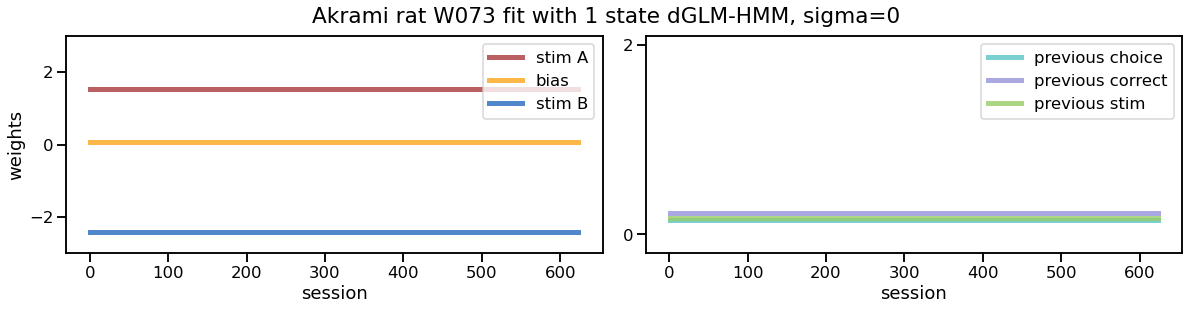

In [18]:
rat_id = 'W073'
stage_filter = 3
folds = 3
K = 1
allW = np.load(f'../data/W_PWM_{rat_id}_sf={stage_filter}_{K}_state_fold-0_multiple_sigmas.npy')
sigmaList = [0] + [10**x for x in list(np.arange(-4,1,0.5, dtype=float))] + [10**x for x in list(np.arange(1,6,1, dtype=float))]
fig, axes = plt.subplots(nrows=1, ncols=2, sharex=False, sharey=False, figsize=(20,4))
fig.suptitle(f'Akrami rat W073 fit with 1 state dGLM-HMM, sigma={np.round(sigmaList[0],4)}')
fig.subplots_adjust(wspace=0.08)
plotting_weights_PWM(w=allW[0], sessInd=trainSessInd[0], axes=axes, sessStop=None, title=f'Akrami rat W073 fit with 1 state dGLM-HMM, sigma={np.round(sigmaList[0],4)}', save_fig=True)
# fig, axes = plt.subplots(nrows=1, ncols=2, sharex=False, sharey=False, figsize=(20,4))
# fig.suptitle(f'Akrami example rat W073 - 1 state dGLM-HMM, sigma={np.round(sigmaList[8],4)}')
# fig.subplots_adjust(wspace=0.08)
# plotting_weights_PWM(w=allW[8], sessInd=trainSessInd, axes=axes, sessStop=179, title=f'Akrami W073 - 1 state dGLM-HMM, sigma={np.round(sigmaList[8],4)}', save_fig=True)
        

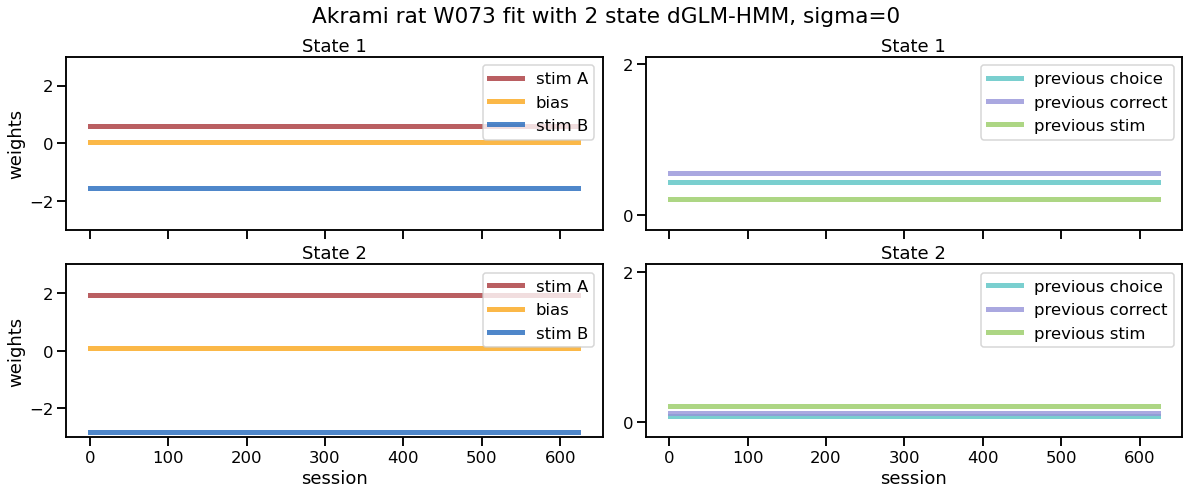

In [29]:
rat_id = 'W073'
stage_filter = 2
folds = 3
K = 2
allW = np.load(f'../data/W_PWM_{rat_id}_sf={stage_filter}_{K}_state_fold-0_multiple_sigmas.npy')
sigmaList = [0] + [10**x for x in list(np.arange(-4,1,0.5, dtype=float))] + [10**x for x in list(np.arange(1,6,1, dtype=float))]
fig, axes = plt.subplots(nrows=2, ncols=2, sharex=True, sharey=False, figsize=(20,7))
fig.suptitle(f'Akrami rat W073 fit with 2 state dGLM-HMM, sigma={np.round(sigmaList[0],4)}')
fig.subplots_adjust(hspace=0.2,wspace=0.08)
plotting_weights_PWM(w=allW[0], sessInd=trainSessInd[0], axes=axes, sessStop=None, title=f'Akrami rat W073 fit with 2 state dGLM-HMM, sigma={np.round(sigmaList[0],4)}', save_fig=True)
# fig, axes = plt.subplots(nrows=1, ncols=2, sharex=False, sharey=False, figsize=(20,4))
# fig.suptitle(f'Akrami example rat W073 - 1 state dGLM-HMM, sigma={np.round(sigmaList[8],4)}')
# fig.subplots_adjust(wspace=0.08)
# plotting_weights_PWM(w=allW[8], sessInd=trainSessInd, axes=axes, sessStop=179, title=f'Akrami W073 - 1 state dGLM-HMM, sigma={np.round(sigmaList[8],4)}', save_fig=True)
     

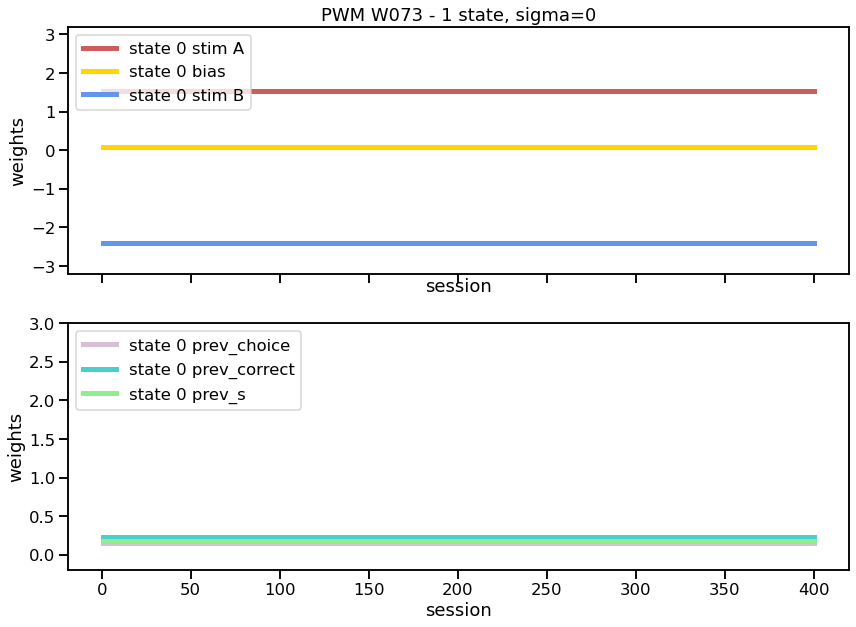

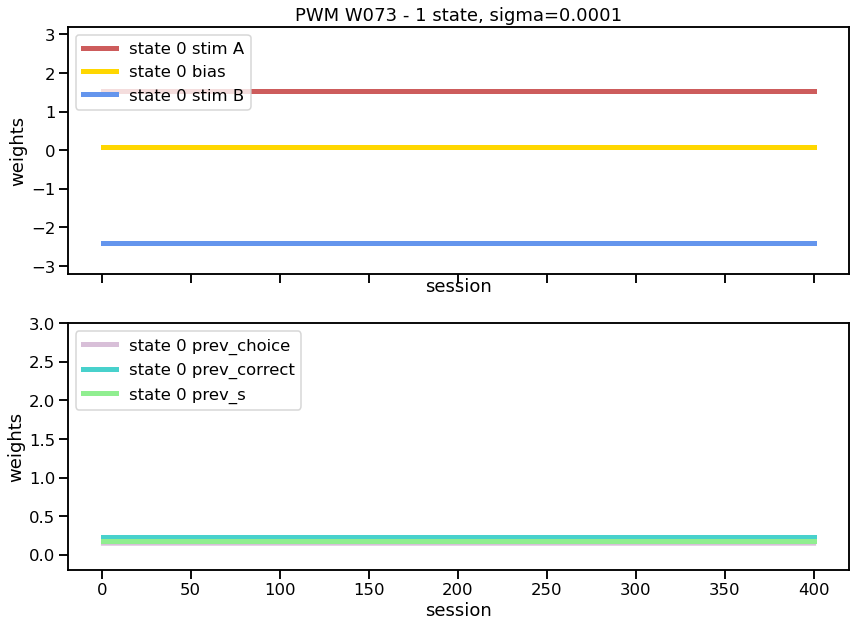

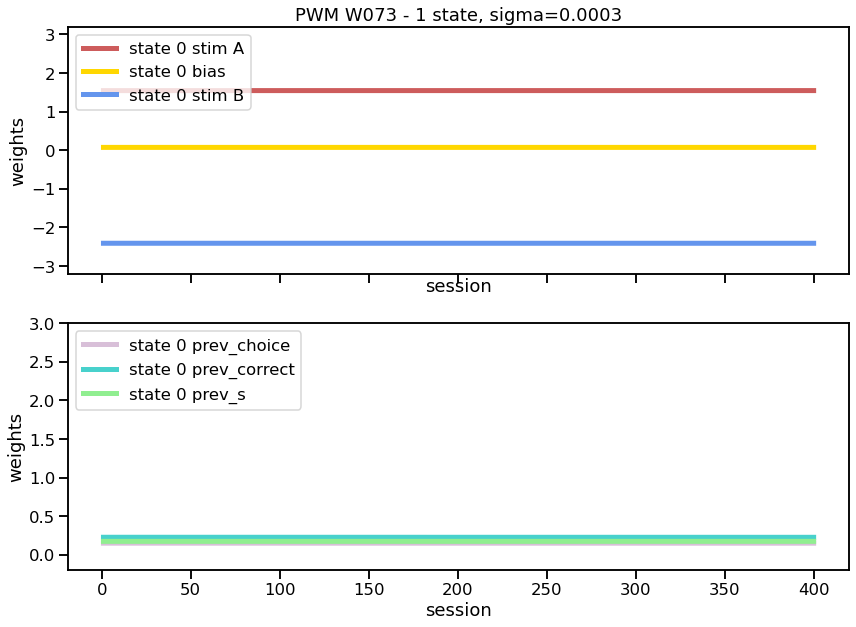

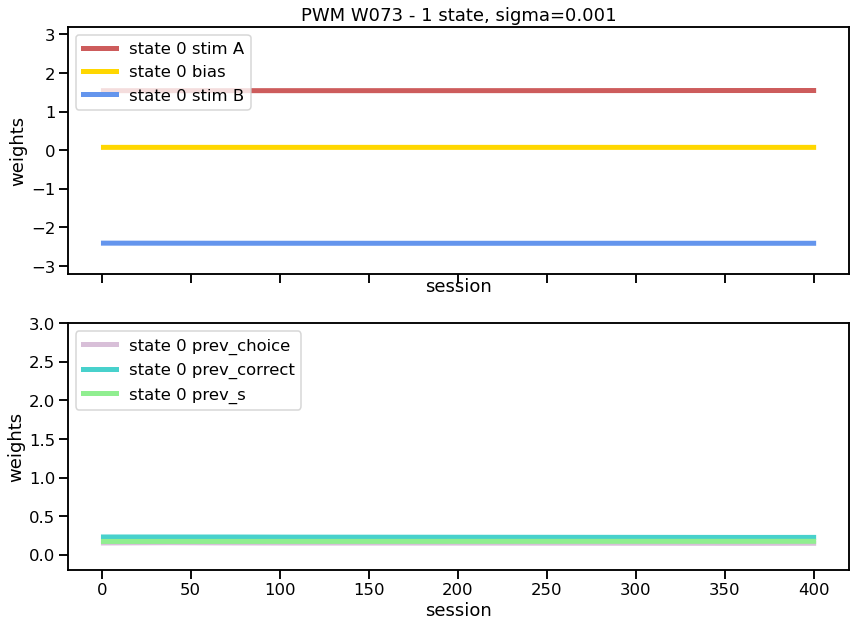

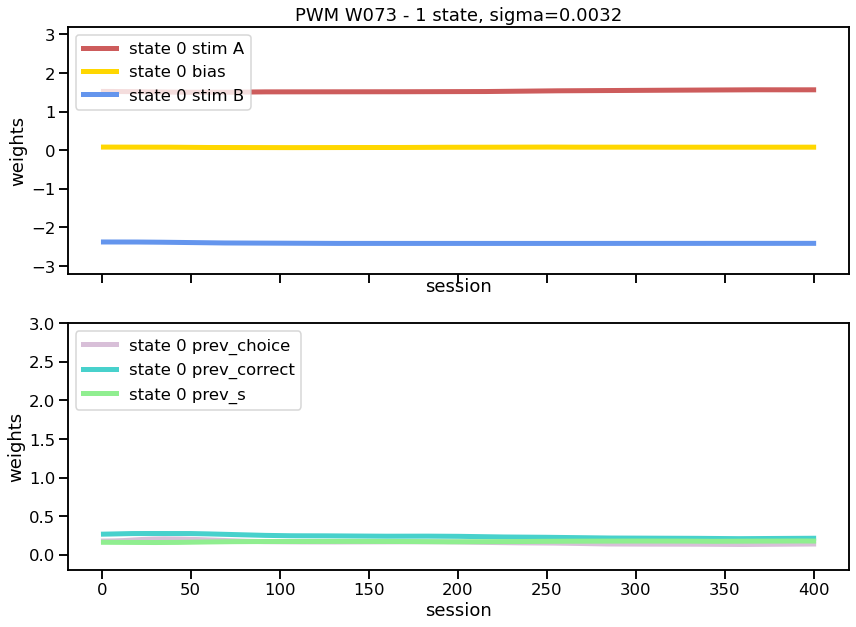

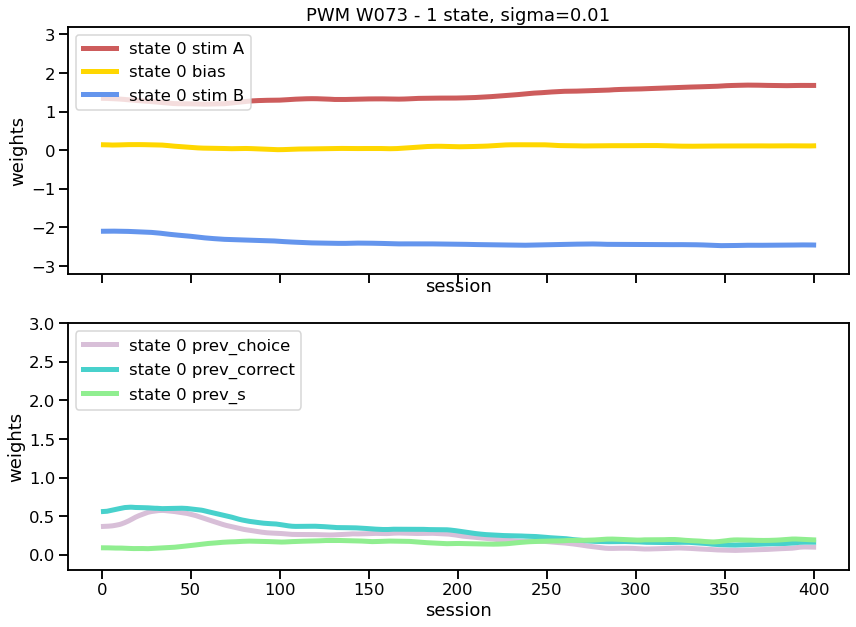

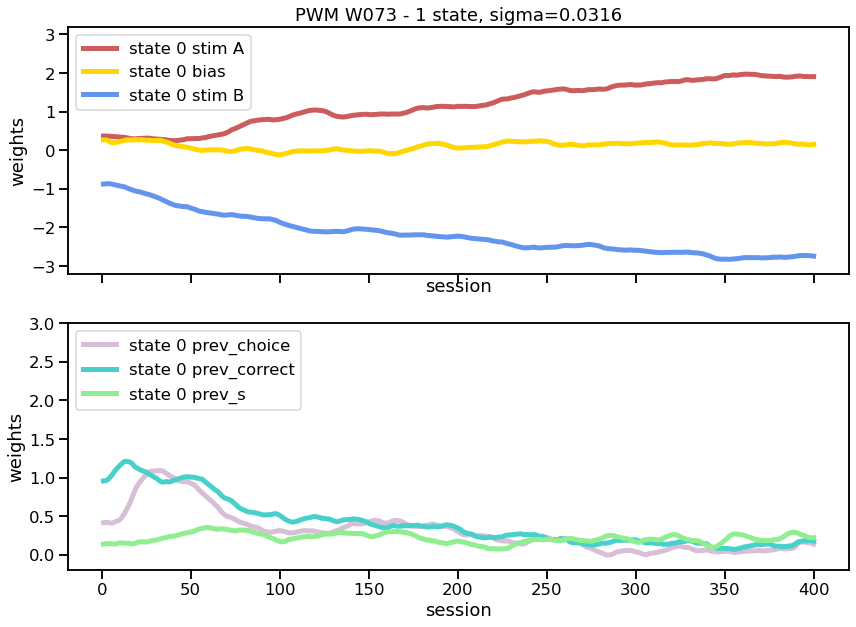

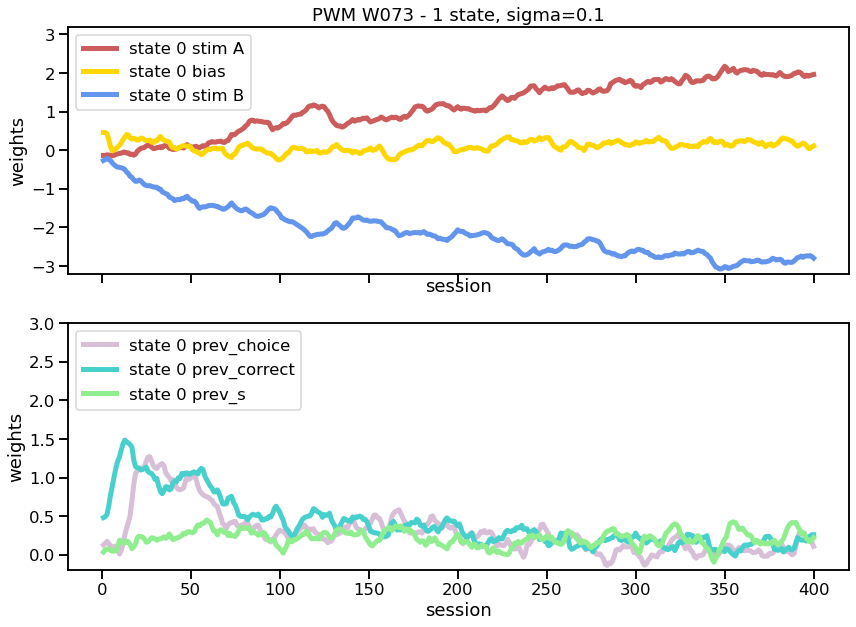

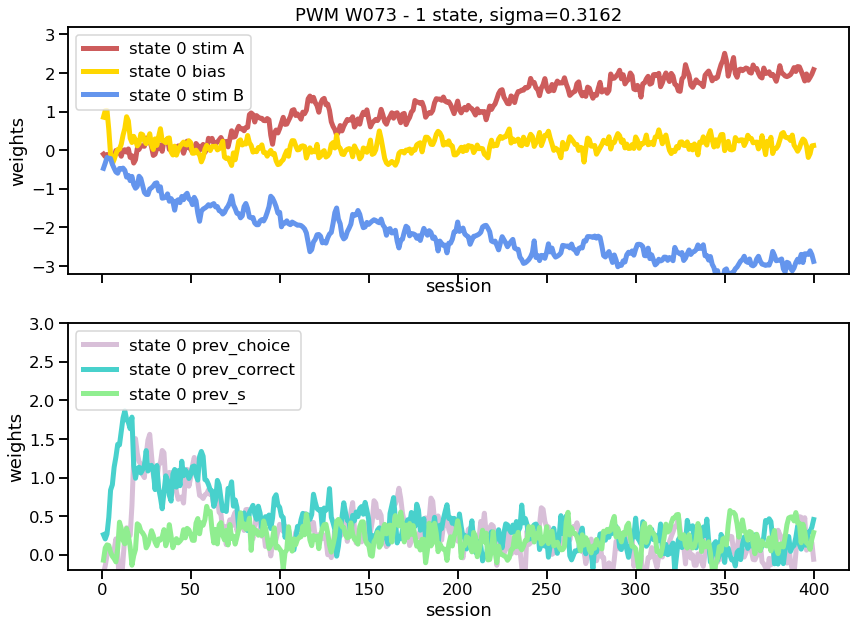

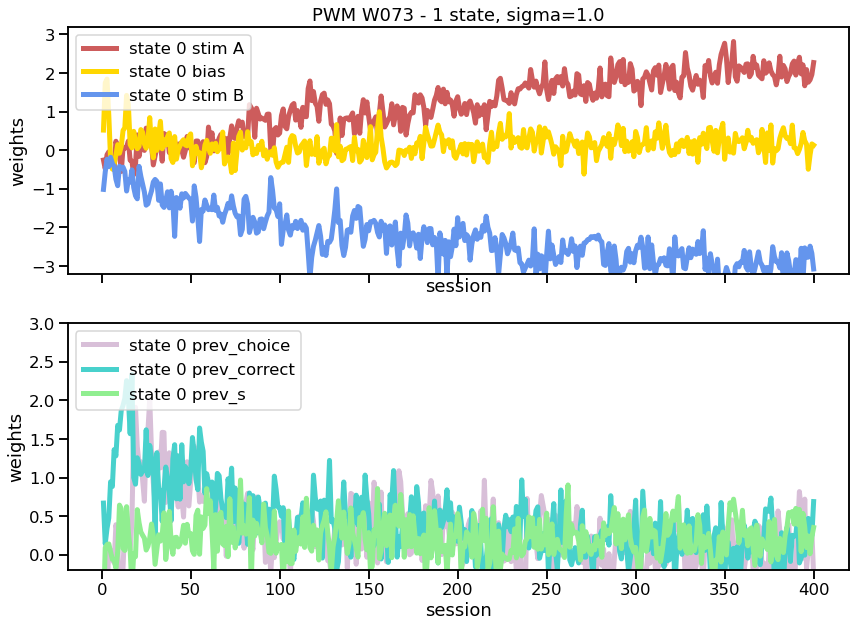

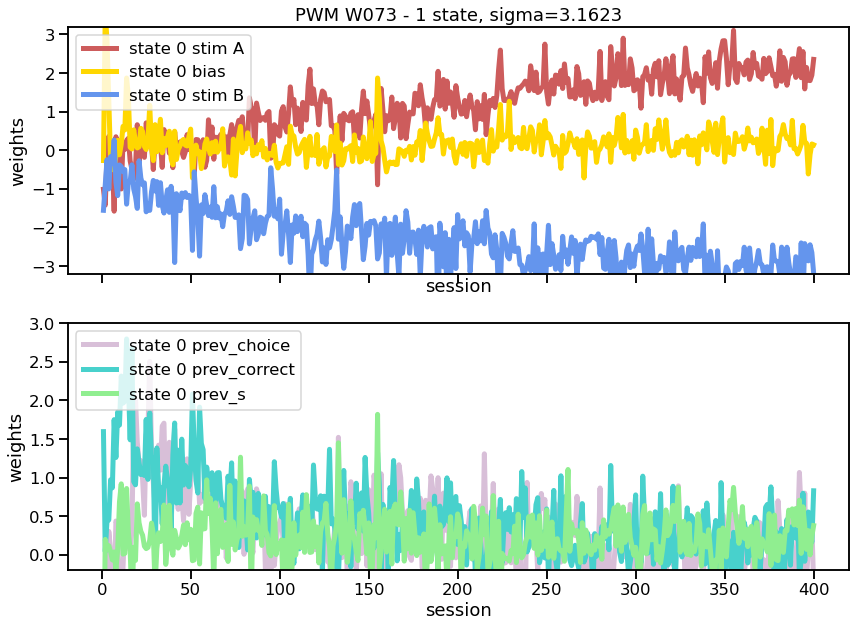

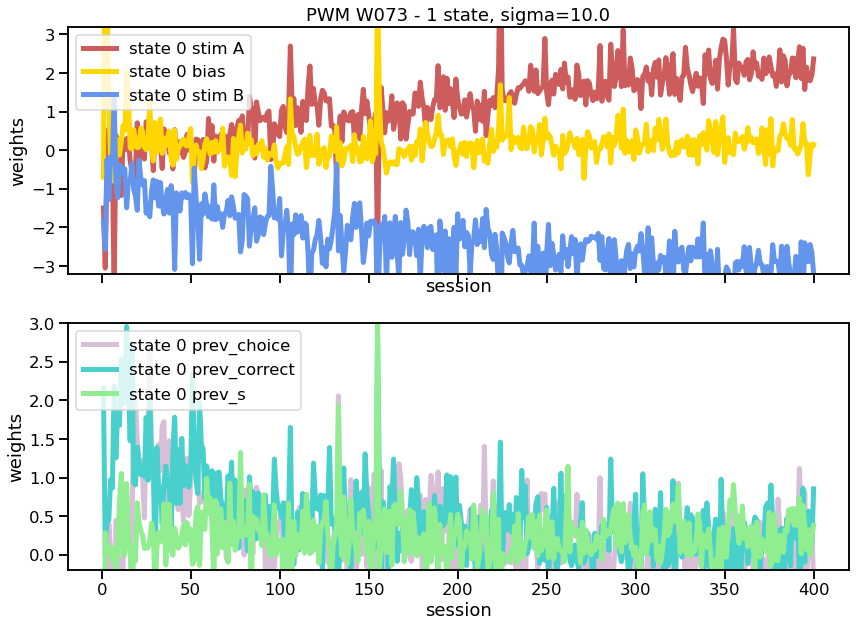

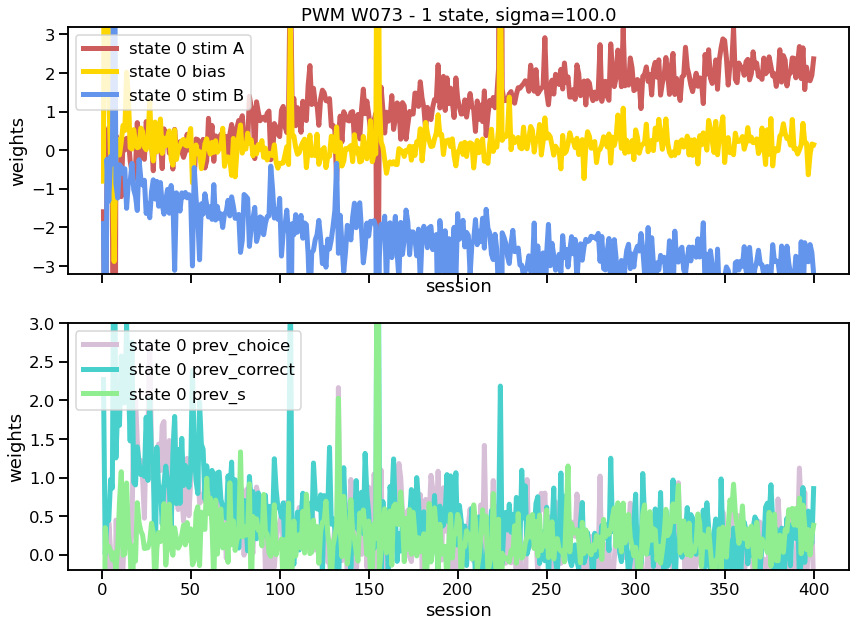

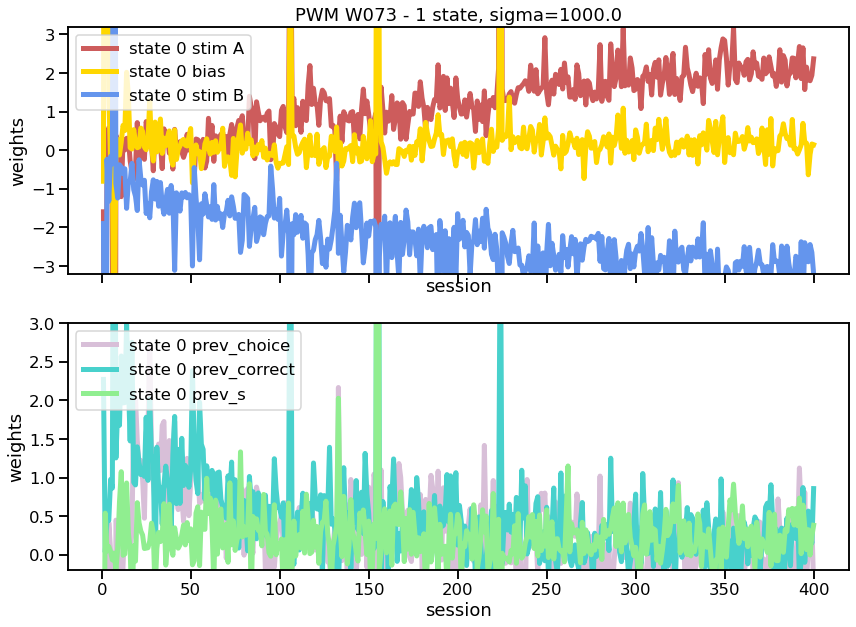

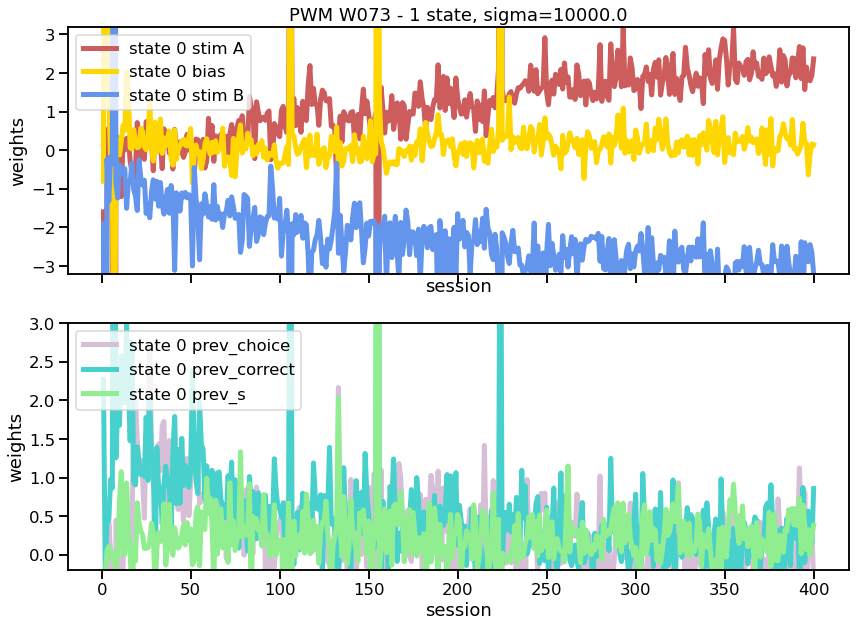

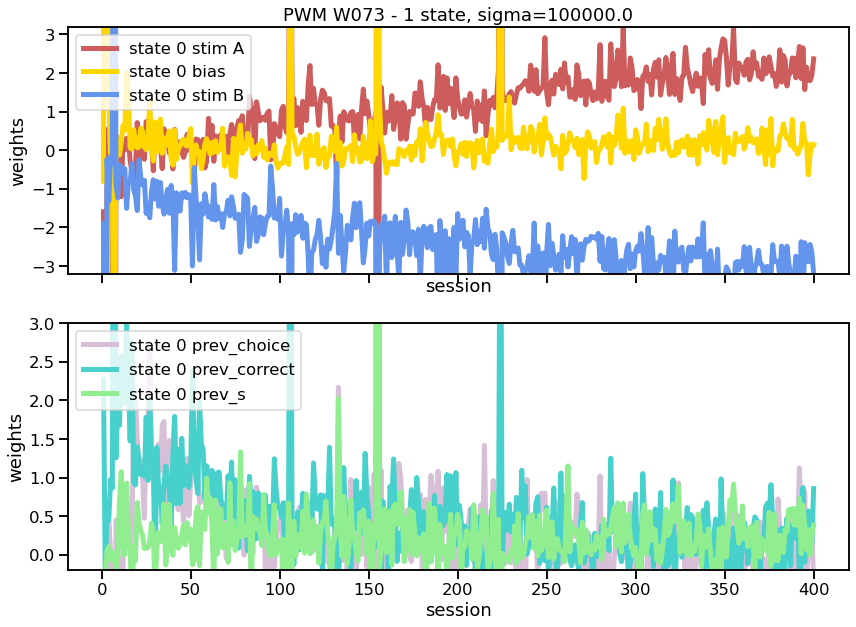

In [23]:
rat_id = 'W073'
stage_filter = 3
folds = 3
K = 1
sigmaList = [0] + [10**x for x in list(np.arange(-4,1,0.5, dtype=float))] + [10**x for x in list(np.arange(1,6,1, dtype=float))]
# PLOTTING WEIGHTS ACROSS MULTIPLE SIGMAS
for fold in range(0,1):
    trainSessInd = np.load(f'../data/trainSessInd_PWM_{rat_id}_sf={stage_filter}_{K}_state_fold-{fold}_multiple_sigmas.npy')
    testSessInd = np.load(f'../data/testSessInd_PWM_{rat_id}_sf={stage_filter}_{K}_state_fold-{fold}_multiple_sigmas.npy')
    allP = np.load(f'../data/P_PWM_{rat_id}_sf={stage_filter}_{K}_state_fold-{fold}_multiple_sigmas.npy')
    allW = np.load(f'../data/W_PWM_{rat_id}_sf={stage_filter}_{K}_state_fold-{fold}_multiple_sigmas.npy')
    for indSigma in range(0, len(sigmaList)):
        fig, axes = plt.subplots(nrows=2, ncols=1, sharex=True, sharey=False, figsize=(14,10))
        plotting_weights_PWM(w=allW[indSigma], sessInd=trainSessInd, axes=axes, sessStop=400, title=f'PWM W073 - 1 state, sigma={np.round(sigmaList[indSigma],4)}', save_fig=False)
        

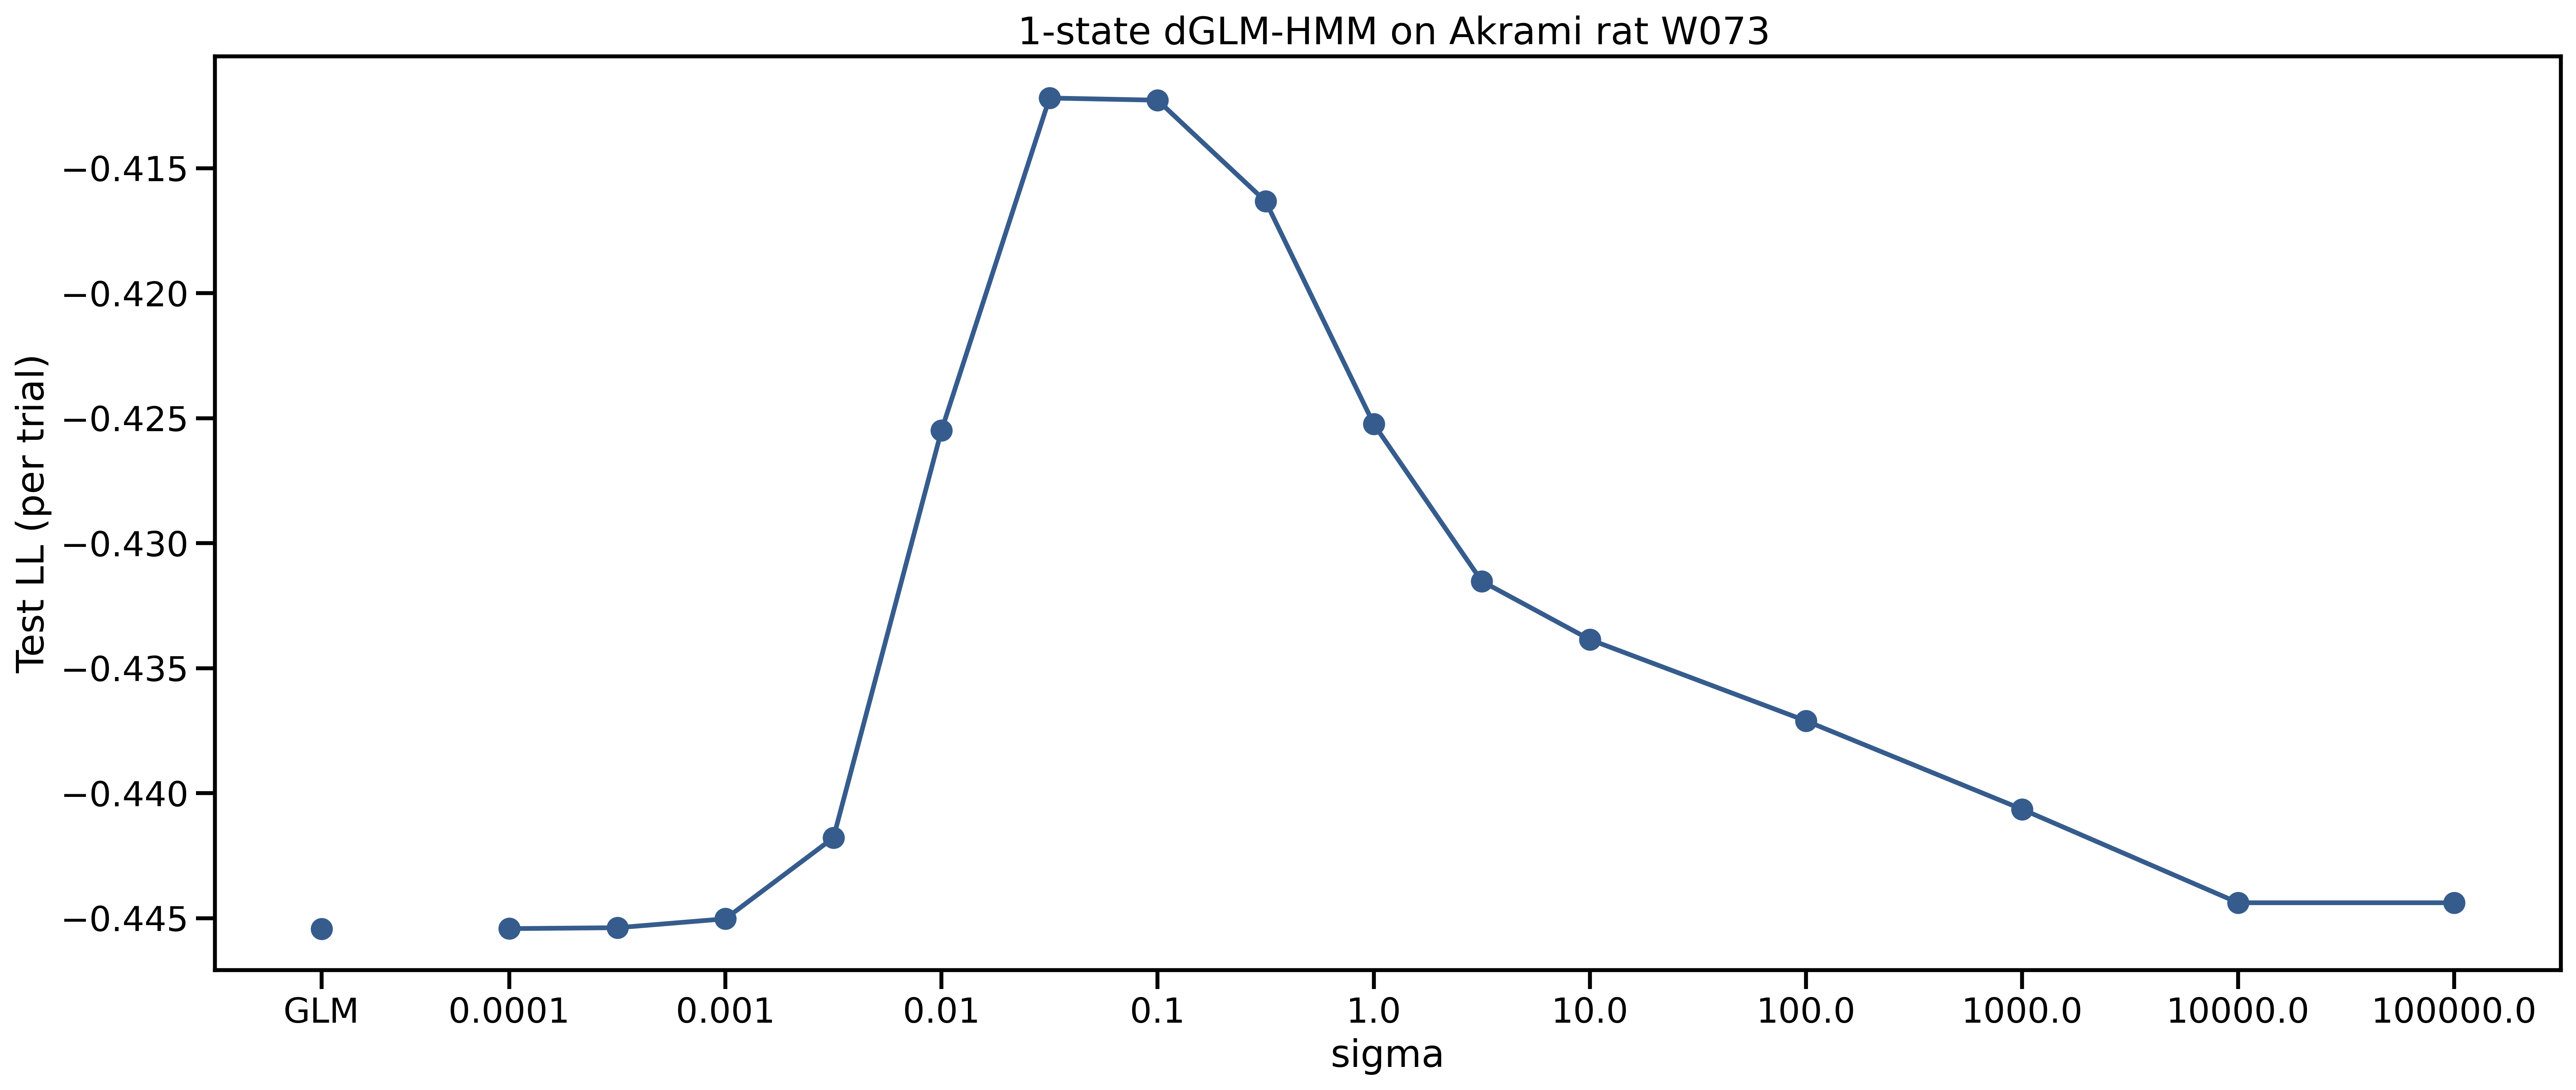

In [5]:
fig, axes = plt.subplots(1,figsize=(20,8), dpi=400)
sigmaList = [0] + [10**x for x in list(np.arange(-4,1,0.5, dtype=float))] + [10**x for x in list(np.arange(1,6,1, dtype=float))]
rat_id='W073'
sigma_CV_testLl_plot_PWM(rat_id='W073', stage_filter=3, K=1, folds=1, sigmaList=sigmaList, axes=axes, title=f' 1-state dGLM-HMM on Akrami rat {rat_id}', save_fig=True)

IndexError: list index out of range

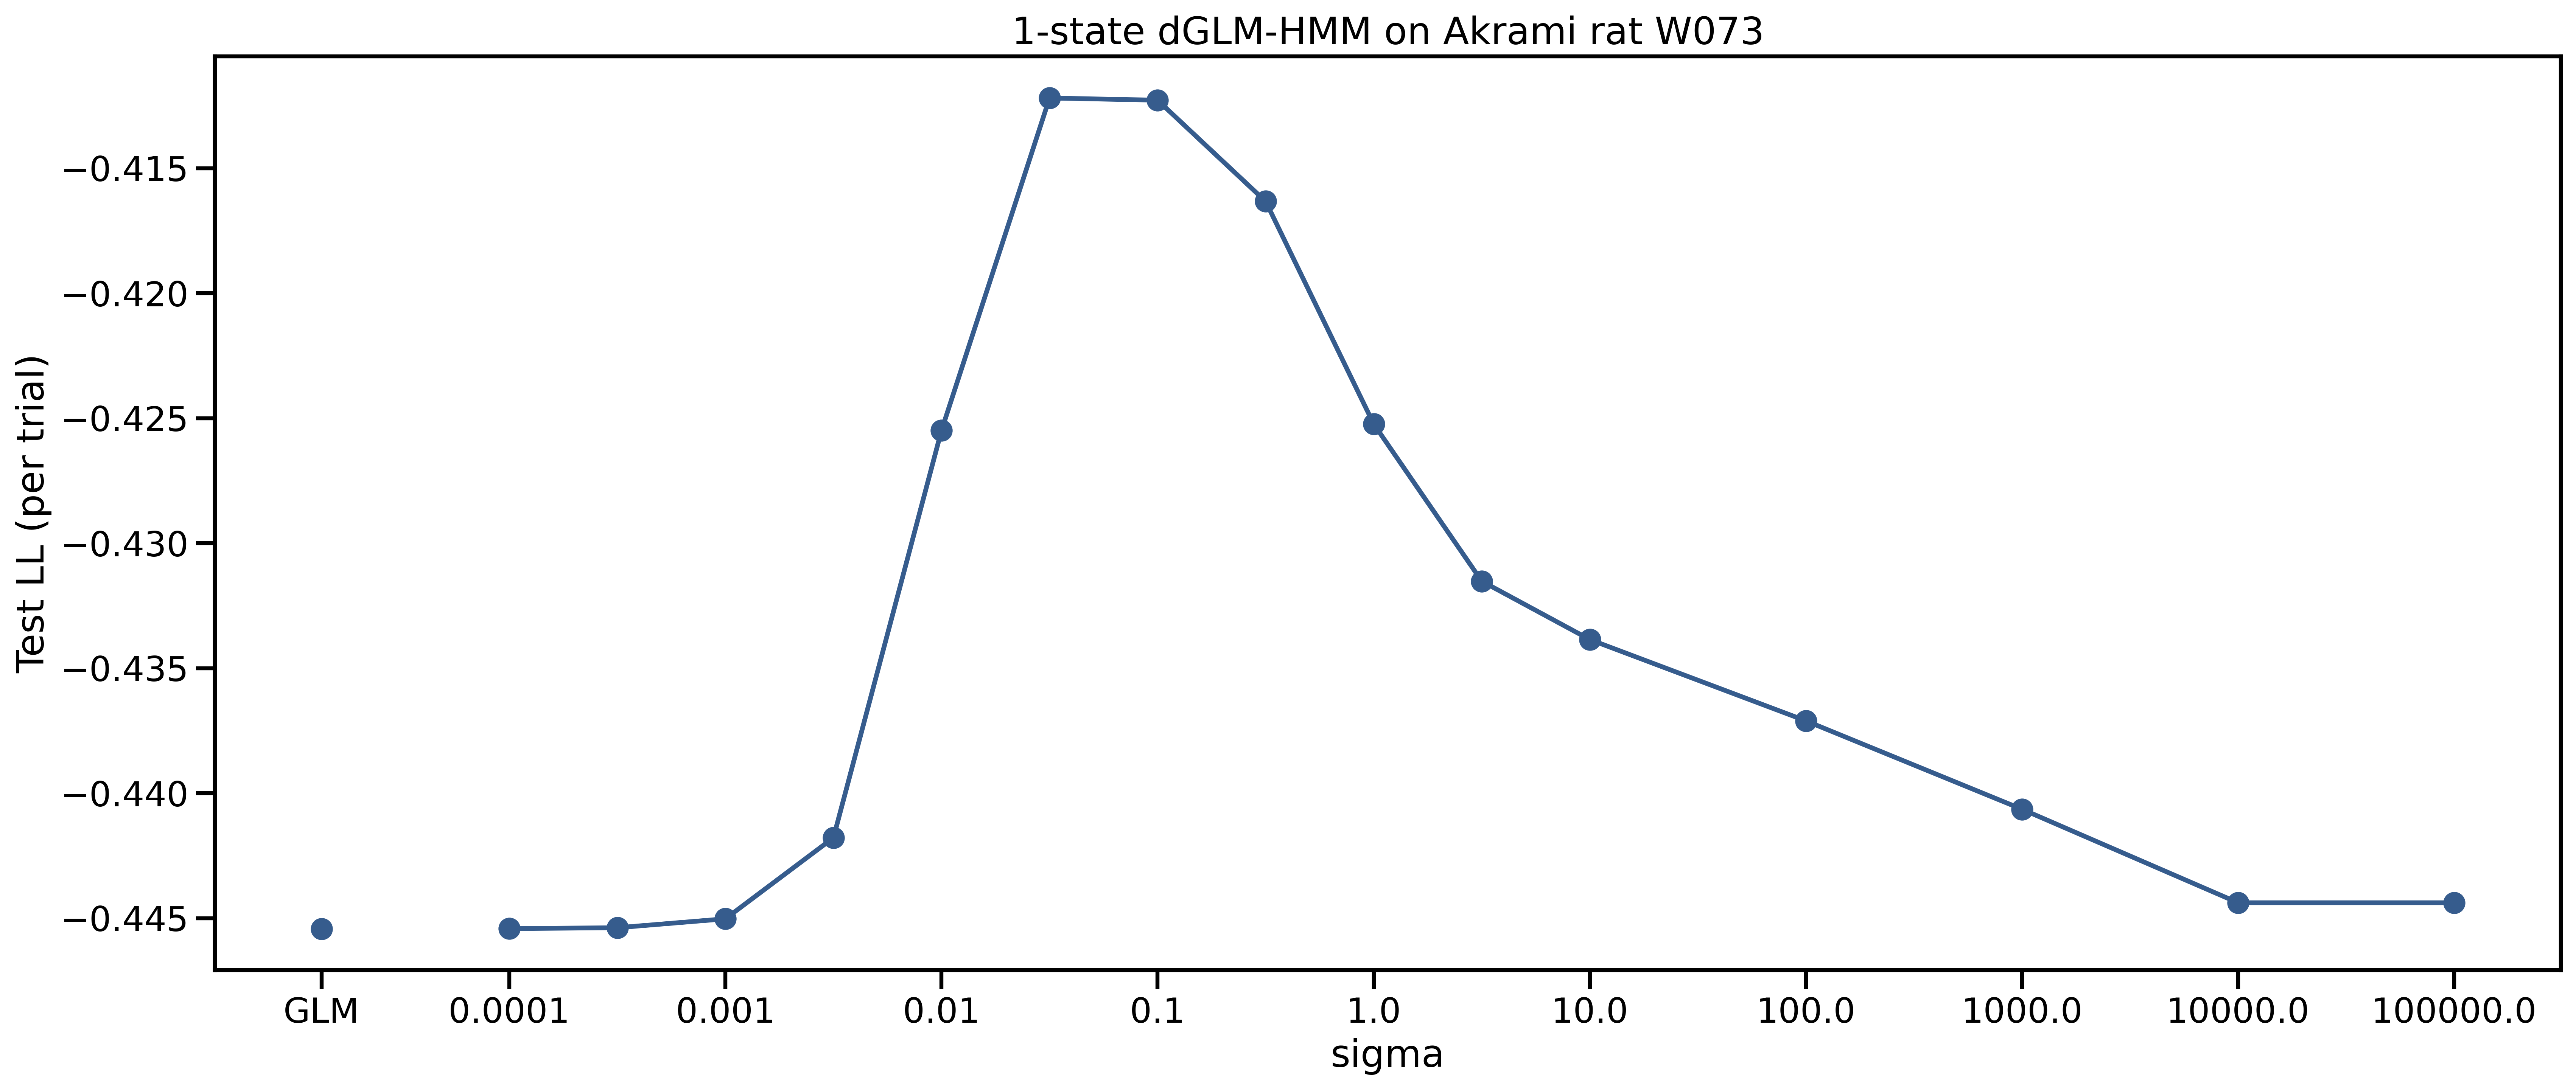

In [10]:
fig, axes = plt.subplots(1,figsize=(20,8), dpi=400)
rat_id='W073'
sigmaList = [0] + [10**x for x in list(np.arange(-4,1,0.5, dtype=float))] + [10**x for x in list(np.arange(1,6,1, dtype=float))]
rat_id='W073'
sigma_CV_testLl_plot_PWM(rat_id='W073', stage_filter=3, K=1, folds=1, sigmaList=sigmaList, axes=axes, title=f'1-state dGLM-HMM on Akrami rat {rat_id}', save_fig=False)
sigmaList = [0, 0.01, 0.1, 1, 10, 100]
sigma_CV_testLl_plot_PWM(rat_id='W073', stage_filter=2, K=2, folds=1, sigmaList=sigmaList, axes=axes, title=f'2-state dGLM-HMM on Akrami rat {rat_id}', save_fig=False)

### Verifying against PsyTrack

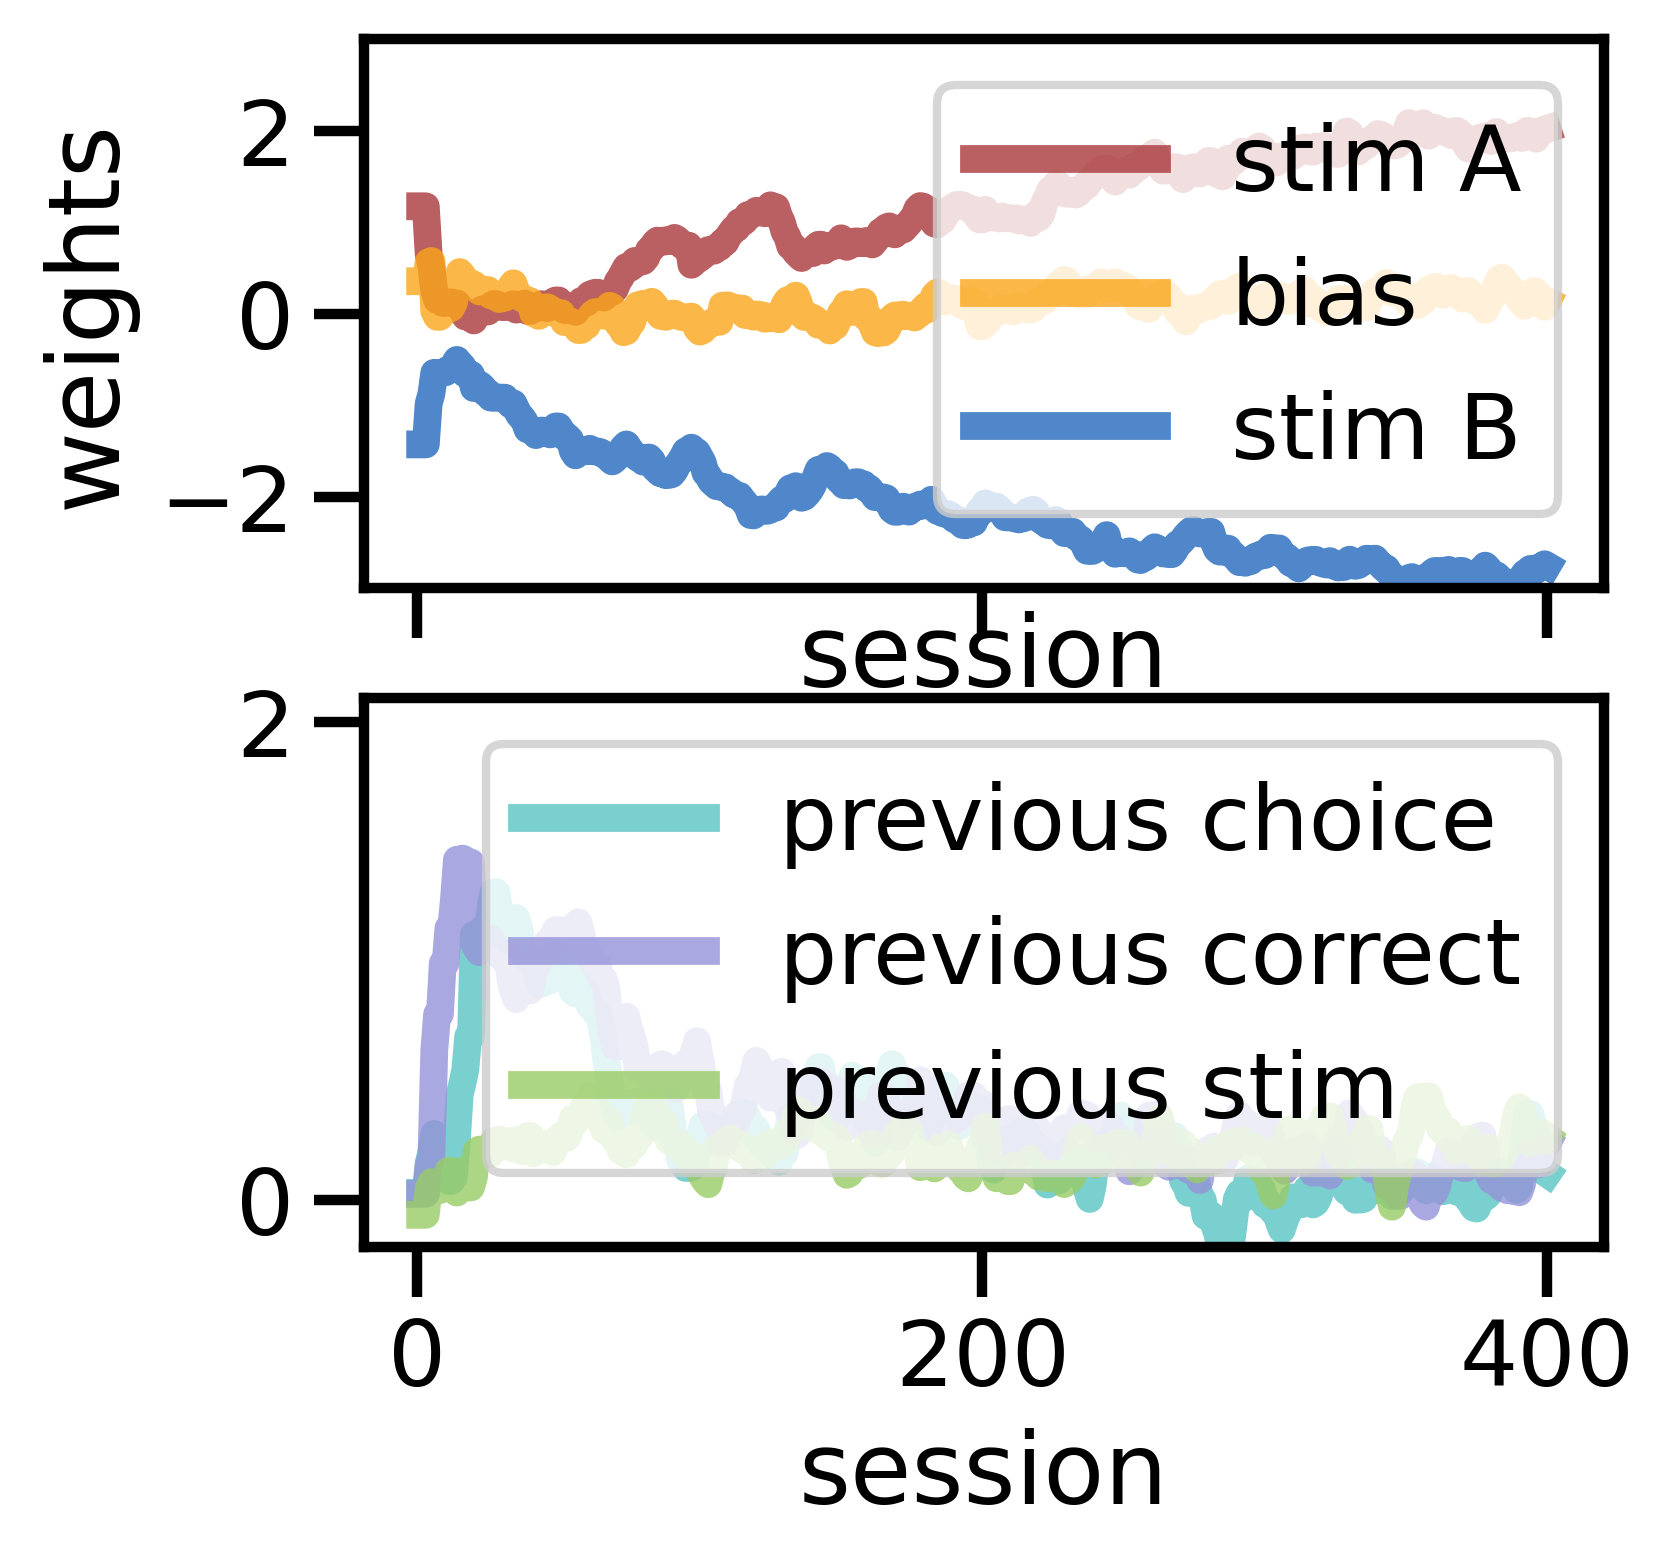

In [25]:
checkP = np.load(f'../data/P_1_state_PWM.npy')
checkLl = np.load(f'../data/Ll_1_state_PWM.npy')
checkW = np.load(f'../data/W_1_state_PWM.npy')

fig, axes = plt.subplots(nrows=2, ncols=1, sharex=True, sharey=False, figsize=(4,4), dpi=400)
def plotting_weights_PWM(w, sessInd, axes, sessStop=None, title='', save_fig=False):
    K = w.shape[1]
    sess = len(sessInd)-1

    if (K==1):
        if (sessStop==None):
            axes[1].plot(range(1,sess+1),w[sessInd[:-1],0,4,0],color='#59C3C3', linewidth=5, label='previous choice', alpha=0.8)
            axes[1].plot(range(1,sess+1),w[sessInd[:-1],0,5,0],color='#9593D9',linewidth=5, label='previous correct', alpha=0.8)
            axes[1].plot(range(1,sess+1),w[sessInd[:-1],0,3,0],color='#99CC66',linewidth=5, label='previous stim', alpha=0.8)
            axes[0].plot(range(1,sess+1),w[sessInd[:-1],0,1,0],color="#A9373B",linewidth=5,label='stim A', alpha=0.8)
            axes[0].plot(range(1,sess+1),w[sessInd[:-1],0,0,0],color='#FAA61A',linewidth=5, label='bias', alpha=0.8)
            axes[0].plot(range(1,sess+1),w[sessInd[:-1],0,2,0],color="#2369BD",linewidth=5, label='stim B', alpha=0.8)
        else:
            axes[1].plot(range(1,sessStop+1),w[sessInd[:sessStop],0,4,0],color='#59C3C3', linewidth=5, label='previous choice', alpha=0.8)
            axes[1].plot(range(1,sessStop+1),w[sessInd[:sessStop],0,5,0],color='#9593D9',linewidth=5, label='previous correct', alpha=0.8)
            axes[1].plot(range(1,sessStop+1),w[sessInd[:sessStop],0,3,0],color='#99CC66',linewidth=5, label='previous stim', alpha=0.8)
            axes[0].plot(range(1,sessStop+1),w[sessInd[:sessStop],0,1,0],color="#A9373B",linewidth=5,label='stim A', alpha=0.8)
            axes[0].plot(range(1,sessStop+1),w[sessInd[:sessStop],0,0,0],color='#FAA61A',linewidth=5, label='bias', alpha=0.8)
            axes[0].plot(range(1,sessStop+1),w[sessInd[:sessStop],0,2,0],color="#2369BD",linewidth=5, label='stim B', alpha=0.8)

        #axes[0].set_title(title)
        axes[0].set_ylabel("weights")
        axes[0].set_xlabel('session')
        axes[0].set_yticks([-2,0,2])
        axes[0].set_ylim(-3,3)
        axes[1].set_ylim(-0.2,2.1)
        axes[1].set_yticks([0,2])
        #axes[1].set_ylabel("weights")
        axes[1].set_xlabel('session')

        axes[0].legend(loc='upper right')
        axes[1].legend(loc='upper right')

    elif(K >= 2):
        for i in range(0,K):
            if (sessStop==None):
                axes[i,1].plot(range(1,sess+1),w[sessInd[:-1],i,4,0],color='#59C3C3', linewidth=5, label='previous choice', alpha=0.8)
                axes[i,1].plot(range(1,sess+1),w[sessInd[:-1],i,5,0],color='#9593D9',linewidth=5, label='previous correct', alpha=0.8)
                axes[i,1].plot(range(1,sess+1),w[sessInd[:-1],i,3,0],color='#99CC66',linewidth=5, label='previous stim', alpha=0.8)
                axes[i,0].plot(range(1,sess+1),w[sessInd[:-1],i,1,0],color="#A9373B",linewidth=5,label='stim A', alpha=0.8)
                axes[i,0].plot(range(1,sess+1),w[sessInd[:-1],i,0,0],color='#FAA61A',linewidth=5, label='bias', alpha=0.8)
                axes[i,0].plot(range(1,sess+1),w[sessInd[:-1],i,2,0],color="#2369BD",linewidth=5, label='stim B', alpha=0.8)
            else:
                axes[i,1].plot(range(1,sessStop+1),w[sessInd[:sessStop],i,4,0],color='#59C3C3', linewidth=5, label='previous choice', alpha=0.8)
                axes[i,1].plot(range(1,sessStop+1),w[sessInd[:sessStop],i,5,0],color='#9593D9',linewidth=5, label='previous correct', alpha=0.8)
                axes[i,1].plot(range(1,sessStop+1),w[sessInd[:sessStop],i,3,0],color='#99CC66',linewidth=5, label='previous stim', alpha=0.8)
                axes[i,0].plot(range(1,sessStop+1),w[sessInd[:sessStop],i,1,0],color="#A9373B",linewidth=5,label='stim A', alpha=0.8)
                axes[i,0].plot(range(1,sessStop+1),w[sessInd[:sessStop],i,0,0],color='#FAA61A',linewidth=5, label='bias', alpha=0.8)
                axes[i,0].plot(range(1,sessStop+1),w[sessInd[:sessStop],i,2,0],color="#2369BD",linewidth=5, label='stim B', alpha=0.8)

            axes[i,0].set_title(f'State {i+1}')
            axes[i,1].set_title(f'State {i+1}')
            axes[i,0].set_ylabel("weights")
            axes[i,0].set_yticks([-2,0,2])
            axes[i,0].set_ylim(-3,3)
            axes[i,1].set_ylim(-0.2,2.1)
            axes[i,1].set_yticks([0,2])
            #axes[1].set_ylabel("weights")
            if (i==K-1):
                axes[i,0].set_xlabel('session')
                axes[i,1].set_xlabel('session')
            axes[i,0].legend(loc='upper right')
            axes[i,1].legend(loc='upper right')

    if(save_fig==True):
        plt.savefig(f'../figures/Weights_PWM_{title}.png', bbox_inches='tight', dpi=400)


plotting_weights_PWM(w=checkW, sessInd=sessInd, axes=axes, sessStop=400, save_fig=False)


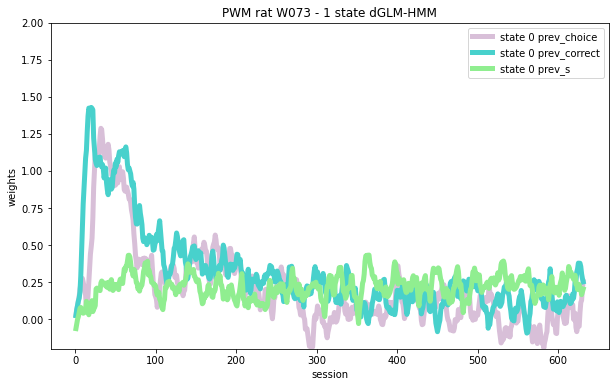

In [38]:
sess = len(sessInd)-1
plt.figure(figsize=(10,6))


plt.plot(range(1,sess+1),checkW[sessInd[:-1],0,4,0],color='thistle', linewidth=5, label='state 0 prev_choice')
plt.plot(range(1,sess+1),checkW[sessInd[:-1],0,5,0],color='mediumturquoise',linewidth=5, label='state 0 prev_correct')
plt.plot(range(1,sess+1),checkW[sessInd[:-1],0,3,0],color='lightgreen',linewidth=5, label='state 0 prev_s')

plt.ylim(-0.2,2)
plt.title('PWM rat W073 - 1 state dGLM-HMM')
#plt.xticks(range(1,sess+1))
plt.ylabel("weights")
plt.xlabel('session')
plt.legend()
#plt.legend(fontsize='xx-small')
plt.show()

### Verifying against GLM-HMM from Brody lab project

In [ ]:
x, y = io_utils.prepare_design_matrices(rat_id='W073', path=None, psychometric=True, cutoff=10, stage_filter=2, overwrite=False)
sessInd = list(io_utils.session_start(rat_id='W073', path=None, psychometric=True, cutoff=10, stage_filter=2))
N = x.shape[0]
C = 2 # classes
K = 1 # states
D = x.shape[1]
dGLM_HMM = dglm_hmm1.dGLM_HMM1(N,K,D,C)
initP, initW = dGLM_HMM.generate_param(sessInd=sessInd, transitionDistribution=['dirichlet', (5, 1)], weightDistribution=['uniform', (-2,2)]) # initialize the model parameters
checkP, checkW, checkLl = dGLM_HMM.fit(x, y,  initP, initW, sigma= reshapeSigma(0.1, K, D), sessInd=sessInd, pi0=None, maxIter=2, tol=1e-4) # fit the model
print(np.argmax(checkLl))

In [ ]:
x, y = io_utils.prepare_design_matrices(rat_id='W075', path=None, psychometric=True, cutoff=10, stage_filter=2, overwrite=False)
sessInd = list(io_utils.session_start(rat_id='W075', path=None, psychometric=True, cutoff=10, stage_filter=2))
N = x.shape[0]
C = 2 # classes
K = 2 # states
D = x.shape[1]
dGLM_HMM = dglm_hmm1.dGLM_HMM1(N,K,D,C)
initP, initW = dGLM_HMM.generate_param(sessInd=sessInd, transitionDistribution=['dirichlet', (5, 1)], weightDistribution=['uniform', (-2,2)]) # initialize the model parameters
checkP, checkW, checkLl = dGLM_HMM.fit(x, y,  initP, initW, sigma= reshapeSigma(0.1, K, D), sessInd=sessInd, pi0=None, maxIter=2, tol=1e-4) # fit the model
print(np.argmax(checkLl))